In [1]:
import torch
import os
from scripts.utils.utils import summarize_attributions

In [2]:
integrated_gradients = "ig"
lime = "lime"
shap = "shap"

load = integrated_gradients

In [3]:
with torch.no_grad():
    models = {}
    for item in os.listdir(f"./pt/liar/{load}/"):
        models[item] = []
        for idx, pt in enumerate(os.listdir(f"./pt/liar/{load}/{item}")):
            pt: torch.Tensor = torch.load(f"./pt/liar/{load}/{item}/{pt}")[0]
            if load != integrated_gradients:
                models[item].append(pt.detach())
            else:
                models[item].append(summarize_attributions(pt.detach()))
models.keys()

dict_keys(['Llama-2-7b-chat-hf', 'Orca-2-7b', 'falcon-7b-instruct', 'Mistral-7B-Instruct-v0.2'])

[Text(0, 0, 'Llama-2-7b-chat-hf'),
 Text(1, 0, 'Orca-2-7b'),
 Text(2, 0, 'falcon-7b-instruct'),
 Text(3, 0, 'Mistral-7B-Instruct-v0.2')]

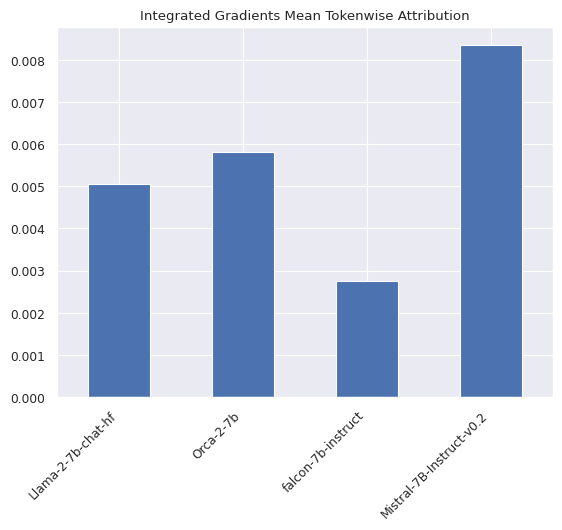

In [4]:
import seaborn as sns
import pandas
sns.set_theme("paper")

meaned = {name: sum([i.mean() for i in item])/len(item) for name, item in models.items()}
df = pandas.DataFrame.from_dict({item: [val.item()] for item, val in meaned.items()})
fig = df.mean().plot(kind="bar")
fig.set_title("Integrated Gradients Mean Tokenwise Attribution")
fig.set_xticklabels(df.columns, rotation=45, ha='right')

In [5]:
sns.set_theme(rc={"figure.figsize": (10, 4)})

In [6]:
if load != integrated_gradients:
    del models['Orca-2-7b']

In [7]:
models['falcon-7b-instruct'][0].shape

torch.Size([74])

Text(0.5, 0, 'Token Contribution')

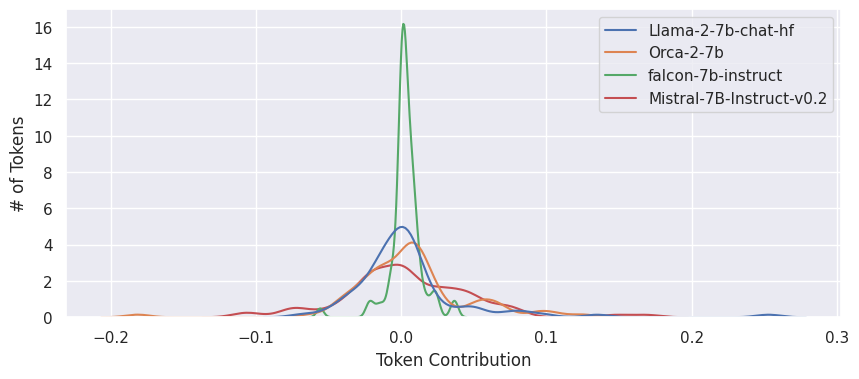

In [8]:
import random
k = 16 # random.randint(0, len(models['falcon-7b-instruct']))
boxplots = sns.kdeplot({model: items[k]  for model, items in models.items()}, bw_adjust=.5)
boxplots.set_ylabel("# of Tokens")
boxplots.set_xlabel("Token Contribution")

In [9]:
# scale each one so that max is 2
scaled_distplot_ready = {model: [(1 / attribution.sum())*attribution for attribution in attributions] for model, attributions in models.items()}

Text(0.5, 0, 'Token Contribution')

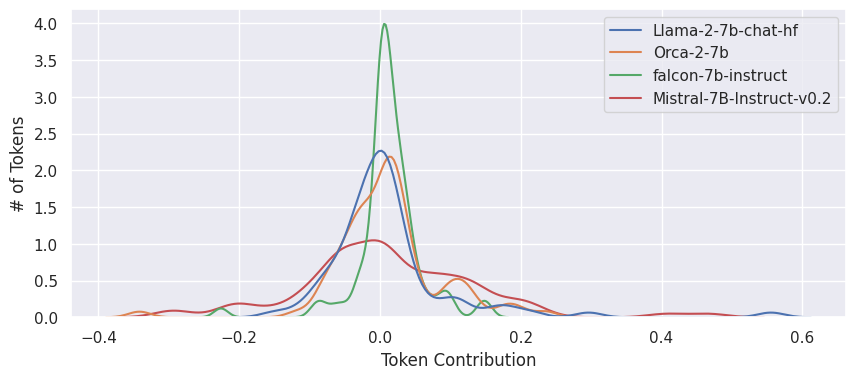

In [10]:
# k = random.randint(0, len(models['falcon-7b-instruct']))
boxplots = sns.kdeplot({model: items[k]  for model, items in scaled_distplot_ready.items()}, bw_adjust=.5)
boxplots.set_ylabel("# of Tokens")
boxplots.set_xlabel("Token Contribution")